# **1. Introduction**

This notebook present the solution of the proposed exercises contained in both exercise lists provided as suplementary material of article entitled "Computational tools for thermodynamic teaching in chemical and metallurgical engineering courses". After definition of the necessary functions, solution of exercises covering evaluation of some thermodynamic properties of pure metals, the solution of the exercesises for Cu - Ni is covered. Both solutions were presented in a step-by-step format, in order to make them clearer for the interested studend.

## **1.1. Libraries import and some definitions.**

In [1]:
#importation of necessary Python  libraries
import math as mt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#Definition of universal gas constant and phases contained in SSOL2 data-base
R = 8.314
all_states = ["FCC_A1", "LIQUID", "HCP_A3", "BCC_A2", "BCT_A5", "DIAMOND_A4", "CBCC_A12", "CUB_A13", "HCP_ZN",
              "RHOMBO_A10", "TETRAGONAL_A6", "RHOMBOHEDRAL_A7", "TET_ALPHA1", "HEXAGONAL_A8", "TETRAG_Ad",
              "DHCP", "BETA_RHOMBO_B", "ORTHORHOMBIC_A20", "TETRAGONAL_U", "GAS (1/2N2)", "ORTHO_Ac",
              "WHITE_P", "RED_P", "BCT_Aa", "ORTHORHOMBIC_S", "MONOCLINIC", "RHOMB_C19", "GRAPHITE", "GAS (1/2O2<g>)",
              "ALPHA_PU", "BETA_PU", "GAMMA_PU", "OMEGA", "ORTHORHOMBIC_GA"]

## **1.2. Basic functions for extracting parameters of molar Gibbs energy models.**

In [3]:
#Function for creating the a list with all phases
def create_list_of_states(all_states):
    full_lst = []
    lst = []

    lst.append(all_states[0])
    for __, dictionary in enumerate(all_states[1::]):

        if "Element" in dictionary:
            full_lst.append(lst)
            lst = []
            lst.append(dictionary)

        else:
            lst.append(dictionary)

    full_lst.append(lst)
    return full_lst

#Function for creating a list of parameters for molar Gibbs energy computation of a specified phase
def load_gibbs(file_name):
    operators = ["+", "-"]
    full_lst = []
    g_coefs = {"temp_range": 0, "a": 0, "b": 0, "c": 0, "d_coef": [], "d_exponent": []}
    g_basic = {"Element": "", "State": "", "A": 0, "a0": 0, "a1": 0, "a2": 0, "a3": 0, "K0": 0, "K1": 0, "K2": 0, "n": 0, "TC": 0, "B0": 0}

    with open(file_name + ".txt") as f:
        for line in f:
            line = line.strip()
            if not line: #skip empty lines
                continue

            if any(s in line for s in all_states): #this means it is the string with the state
                g_coefs = {"temp_range": 0, "a": 0, "b": 0, "c": 0, "d_coef": [], "d_exponent": []}
                g_basic = {"Element": "", "State": "", "A": 0, "a0": 0, "a1": 0, "a2": 0, "a3": 0, "K0": 0, "K1": 0, "K2": 0, "n": 0, "TC": 0, "B0": 0}
                pos = file_name.find("-") #find position of "-" for proper naming
                g_basic.update({"Element": file_name[0:pos], "State": line} )
                full_lst.append(g_basic)

            elif line[0] == "(":  #this means it is the temp. range
                line = line.strip("()").rpartition("< T <")
                g_coefs.update({"temp_range": [float(line[0]), float(line[-1])]})
                full_lst.append(g_coefs)
                g_coefs = {"temp_range": [], "a": [], "b": [], "c": [], "d_coef": [], "d_exponent": []}

            elif line[0] in ["A", "K", "T"]: #line has pressure or magnetic coefs
                line = line.split(" ")
                for i, elem in enumerate(line):
                    if elem == "=":
                        g_basic.update( {line[i-1]: float(line[i+1])} )

            else:
                #append pressure and/or magnetic coefs
                g_basic = {}
                line = line.split(" ")
                g_coefs.update({"a": float(line[0])})

                for i, element in enumerate(line):
                    if element in operators:
                        line[i+1] = "".join(line[i:i+2])  #joins operators with coefs

                    elif "T" in element:
                        if len(element) == 1 and line[i+1] == "ln(T)":  #treats ln(T) term
                            g_coefs.update({"c": float(line[i-1])})

                        elif len(element) == 1 and line[i+1] != "ln(T)": #treats T^1 term
                            g_coefs.update({"b": float(line[i-1])})

                        else: #treats all other terms like T^2, T^3, T^-1
                            if element == "ln(T)":
                                continue
                            exponent = float( element.rpartition("T")[-1] )
                            g_coefs["d_coef"].append( float(line[i-1]) )
                            g_coefs["d_exponent"].append( exponent )

    full_lst = create_list_of_states(full_lst)
    return full_lst

## **1.3. Functions for phase (state) selection and definition of temperature range validity of parameters from molar Gibbs energy models.**

In [4]:
#Selection of a specified phase ("state") from the whole group of phases defined in the data-base
def get_state(state, all_states):
    for i, par in enumerate(all_states):
        if par[0]["State"] == state:
            return par

#Returns the temperature range of validity of the molar Gibbs energy of a specified phase ("state")
def get_temp_range(state):
    return [ state[1]["temp_range"][0], state[-1]["temp_range"][-1] ]

## **1.4. Computation of pressure effects over molar Gibbs energy.**

In [5]:
#returns True if there are pressure coefficients for the state
def check_extra_coefs_pressure(state):
    return state["A"] != 0

In [6]:
#pressure in Pa. returns pressure gibbs
def calc_g_press(state, temp, pressure):
    if check_extra_coefs_pressure(state):
        coef = state
        g_press1 = ( coef["A"] * mt.exp(coef["a0"]*temp + (1/2)*coef["a1"]*temp**2 + (1/3)*coef["a2"]*temp**3 + (1/temp)*coef["a3"]) )
        g_press2 = ( coef["K0"] + coef["K1"]*temp + coef["K2"]*temp**2) * (coef["n"] - 1)
        g_press3 = ( (1 + coef["n"]*pressure*( coef["K0"] + coef["K1"]*temp + coef["K2"]*temp**2 ))**(1 - (1/coef["n"])) - 1)
    else:
        return 0

    return (g_press1 * g_press3)/ g_press2

## 1.4. Computation of magnetic contribution fo molar Gibbs energy

In [7]:
#returns True if there are magnetic coefficients for the state
def check_extra_coefs_magnetic(state):
    return state["B0"] != 0

In [8]:
#Function for reading the corret parameter "p" value for specific magnetic phase (state)
def get_p_value(state):
    if state["State"] == "BCC_A2":
        p = 0.40
    else:
        p = 0.28
    return p

def calc_g_tau(state, temp):
    tau = temp/ state["TC"]
    p = get_p_value(state)
    D = (518/1125) + (11692/15975)*((1/p) - 1)

    if tau > 1:
        g_tau = (-1/D)* (   (tau**-5/10) + (tau**-15/315) + (tau**-25/1500) )
    else:
        g_tau = 1 - (1/D) * (   79/(140*p*tau) + ((474/497)*((1/p) - 1) * (tau**3/6 + tau**9/135 + tau**15/600)))

    return g_tau

def calc_s_tau(state, temp):
    tau = temp/ state["TC"]
    p = get_p_value(state)
    D = (518/1125) + (11692/15975)*((1/p) - 1)

    if tau > 1:
        s_tau = (1/D) * (2/(5*tau**5) + 2/(45*tau**15) + 2/(125*tau**25))
    else:
        s_tau = 1 - (1/D) * (   (474/497)*((1/p) - 1)*(2*tau**3/3 + 2*tau**9/27 + 2*tau**15/75)    )

    return s_tau

def calc_g_mag(state, temp):
    R = 8.314
    if check_extra_coefs_magnetic(state):
        g_tau = calc_g_tau(state, temp)
        g_mag = R*temp*mt.log(state["B0"] + 1)*g_tau

    else:
        return 0

    return g_mag

## **1.5. Functions for computation of molar gibbs, entropy, enthalpy, cp as a function of temperature.**

In [9]:
#Function for calculation of a specific phase (state) molar Gibbs energy at specified temperature.
def aux_calc_gibbs(state, temp):
    sum = 0
    for i, value in enumerate(state["d_coef"]):
        sum = sum + value*temp**state["d_exponent"][i]

    return state["a"] + state["b"]*temp + state["c"]*temp*mt.log(temp) + sum

#Function for calculation of a specific phase (state) molar entropy at specified temperature.
def aux_calc_entropy(state, temp):
    sum = 0
    for i, value in enumerate(state["d_coef"]):
        sum = sum + state["d_exponent"][i]*value*temp**(state["d_exponent"][i] - 1)

    return -state["b"] - state["c"] - state["c"]*mt.log(temp) - sum

#Function for calculation of a specific phase (state) molar enthalpy at specified temperature.
def aux_calc_enthalpy(state, temp):
    sum = 0
    for i, value in enumerate(state["d_coef"]):
        sum = sum + (state["d_exponent"][i] - 1)*value*temp**state["d_exponent"][i]

    return state["a"] - state["c"]*temp - sum

#Function for calculation of a specific phase (state) molar heat capacity (Cp) at specified temperature.
def aux_calc_cp(state, temp):
    sum = 0
    for i, value in enumerate(state["d_coef"]):
        sum = sum + state["d_exponent"][i]*(state["d_exponent"][i] - 1)*value*temp**(state["d_exponent"][i] - 1)

    return -state["c"] - sum

#Function for selecting the thermodynamic property of interest
def aux_calc_thermofunctions(lst, temp, prop):
    match prop:
        case "gibbs":
            aux = aux_calc_gibbs(lst, temp)
        case "entropy":
            aux = aux_calc_entropy(lst, temp)
        case "enthalpy":
            aux = aux_calc_enthalpy(lst, temp)
        case "cp":
            aux = aux_calc_cp(lst, temp)
    return aux

#Function for including magnetic or temperature effects over the computed molar Gibbs energy value (g)
def calc_thermofunctions(par, temp, prop, pressure = 0, calgMag = True):
    g_press = 0
    g_mag = 0

    if pressure != 0: #alterar 1 bar
        for i, element in enumerate(par[1::]):
            if temp > element["temp_range"][0] and temp <= element["temp_range"][1]:
                g_press = calc_g_press(par[0], temp, pressure)

    if check_extra_coefs_magnetic(par[0]) and calgMag == True:
        g_mag = calc_g_mag(par[0], temp)

    for i, element in enumerate(par[1::]):
        # print(f"temp: {temp}")
        if temp > element["temp_range"][0] and temp <= element["temp_range"][1]:
            thermo = aux_calc_thermofunctions(element, temp, prop)
    return thermo + g_press + g_mag

In [10]:
#Function for computing the difference between the molar Gibbs energy of one phase (state) in relation to a specified reference phase
def calc_thermoproperty_relative(all_states, reference, prop, temp_limits, pressure = 0, calcMag = True):
    ref = []
    all_thermo = []
    all_temp_ranges = []
    for state in all_states:
        temp_range = np.linspace(temp_limits[0]*1.0001, temp_limits[1], 10000)
        thermo = []
        for i, temp in enumerate(temp_range): #calc property for every temp
            thermo.append(calc_thermofunctions(state, temp, prop, pressure, calcMag)/1000 )  #stores value converting from J to kJ

            if state[0]["State"] == reference: #store reference state
                ref = thermo

        all_temp_ranges.append(temp_range) #needed when states have different temp_ranges.
        all_thermo.append(thermo)

    if reference != None:
        for i, thermo_state in enumerate(all_thermo):
            all_thermo[i] = [(x - y) for x,y in zip(thermo_state, ref)] #subtract gibbs energies from the reference energy

    return all_thermo, all_temp_ranges, reference

#Function for creating lables and diagram titles
def create_thermo_title_and_ylabel(element, prop, reference):
    match prop:
        case "gibbs":
            title = "Gibbs energy of phases of " + element
            ylabel = "Gibbs energy (kJ mol${^-}{^1}$)"
        case "entropy":
            title = "Entropy of phases of " + element
            ylabel = "Entropy (KJ mol${^-}{^1}$ K${^-}{^1}$)"
        case "enthalpy":
            title = "Enthalpy of phases of " + element
            ylabel = "Enthalpy (KJ mol${^-}{^1}$)"
        case "cp":
            title = "Heat capacity of " + element
            ylabel = "Heat capacity (KJ mol${^-}{^1}$ K${^-}{^1}$)"

    if reference != None:
        title = title + " relative to " + reference

    return title, ylabel

#Function for plotting the desired property ("prop") as a function of temperature
def plot_thermoproperty(original_all_states, all_states, all_temp_ranges, reference, prop):
    fig, ax = plt.subplots(figsize=(9,6), dpi = 300)
    plt.rcParams['font.family'] = 'Serif'
    plt.rcParams.update({'font.size': 9})
    plt.tight_layout()
    fig.set_size_inches(6, 4)

    for i, gibbs_state in enumerate(all_states):
        ax.plot(all_temp_ranges[i], all_states[i], label = original_all_states[i][0]["State"])

    ax.legend()
    title, ylabel = create_thermo_title_and_ylabel(original_all_states[0][0]["Element"], prop, reference)
    ax.set_title(title)
    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel(ylabel)
    ax.grid(True)
    return ax

## **1.6. Functions for Chemical Activity calculation.**

In [11]:
#Function for reading the Ln parameters of sub-regular model
def calc_L_parameter(lst, temp):
    L = 0
    L_list = []
    exponent = 0
    for i in lst:
        for j in i:
            L = L + j*temp**exponent
            exponent = exponent + 1
        exponent = 0
        L_list.append(L)
        L = 0

    return L_list

#Function for calculation of chemical activity of both components based on the sub-regular model
def activity_coefficient(xa, xb, T, lst):
    alfa = 1 / (8.314*T)

    L = calc_L_parameter(lst, T)
    Lab = 0
    for i, val in enumerate(L):
        Lab = Lab + val*(xa-xb)**i

    gama_a = mt.exp(alfa*(Lab*(xb**2) + 2*xa*(xb**2)*L[1]))
    gama_b = mt.exp(alfa*(Lab*(xa**2) - 2*xb*(xa**2)*L[1]))
    return gama_a, gama_b

#Function for computing variable "equilibrium_adjustment" for FCC [0] and liquid [1] phases at specified temperature(temp)
def equilibrium_adjustment(element, states, temp):
    alfa = 1 / (8.314*temp)

    state1 = get_state(states[0], element) #fcc
    state2 = get_state(states[1], element) #liquid

    gibbs1 = calc_thermofunctions(state1, temp, "gibbs")
    gibbs2 = calc_thermofunctions(state2, temp, "gibbs")

    adjustment = mt.exp( alfa*( gibbs2 - gibbs1 ) )

    return adjustment

#returns melting temperature of a pure substance
def melting_temp(stateA, stateB, T = 1000, tol = 1e-9, lt = 0.01):
    #define molar gibbs free energies
    GA = calc_thermofunctions(stateA, T, "gibbs")
    GB = calc_thermofunctions(stateB, T, "gibbs")

    DeltaSL = (GA - GB)

    if DeltaSL >= 0 and abs(DeltaSL) >= tol:
        T = T - lt*DeltaSL
        return melting_temp(stateA, stateB, T)
    elif DeltaSL < 0 and abs(DeltaSL) >= tol:
        T = T - lt*DeltaSL
        return melting_temp(stateA, stateB, T)
    else:
        return T
    return

#Function for determing element of a list with value equal to K
def closest(list, K):
    list = np.asarray(list)
    idx = (np.abs(list - K)).argmin()
    return list[idx], idx

#Function for computing relative and absolute deviations between theoretical (model) and experimental (Thermocalc) values
def error_calculation(a_theoretical, a_experimental, b_theoretical, b_experimental):
    error_absolute = []
    error_relative = []
    for i, _ in enumerate(b_experimental):
        [__, position] = closest(b_theoretical, b_experimental[i])
        error_relative.append( 100 * (a_experimental[i] - a_theoretical[position])/ a_experimental[i] )
        error_absolute.append( a_experimental[i] - a_theoretical[position] )
    return error_absolute, error_relative

#Function for calculating liquidus temperature and associated solid solution composition
def equilibrium_composition(z1, melt_temps, elements, states, L_solid, L_liquid):
    #Tolerances
    tolerance1 = 1e-8
    tolerance2 = 1e-8

    #Initial values for starting the iteration process
    equilibrium_deviation = 1
    d_gama1 = 1
    d_gama2 = 1

    #Parameter for enhancing convergence velocity during temperature guess variation
    convergence_rate = 300

    #Initial guess for solid phase composition
    x1 = z1
    x2 = 1 - z1

    #Liquidus temperature initial guess
    temp_guess = melt_temps[0]*x1 + melt_temps[1]*x2

    while abs(equilibrium_deviation) >= tolerance1:
        [gama_liquid1, gama_liquid2] = activity_coefficient(z1, 1 - z1, temp_guess, L_liquid)
        adjustment1 = equilibrium_adjustment(elements[0], states, temp_guess)
        adjustment2 = equilibrium_adjustment(elements[1], states, temp_guess)

        while d_gama1 >= tolerance2 and d_gama2 >= tolerance2:
            [gama_solid1, gama_solid2] = activity_coefficient(x1, x2, temp_guess, L_solid)

            #metal composition is adjusted
            r_gama1 = adjustment1 * (z1*gama_liquid1) / (x1*gama_solid1)
            d_gama1 = (r_gama1 - 1)**2
            x1 = x1*r_gama1

            #metal2 composition is adjusted
            r_gama2 = adjustment2 * ((1 - z1)*gama_liquid2) / (x2*gama_solid2)
            d_gama2 = (r_gama2 - 1)**2
            x2 = x2*r_gama2

        #Liquidus temperature is adjusted taking the equilibrium deviation into account
        equilibrium_deviation = (x1 + x2) - 1
        temp_guess = temp_guess + (equilibrium_deviation*convergence_rate)

        d_gama1 = 1
        d_gama2 = 1

    x = [x1, x2]
    return x, temp_guess

# **Exercise List 1: Phase -Equilibrium involving pure metals.**

## **1.** Calculate the melting temperatures of copper and nickel and compare the obtained results with the ones from PUBCHEM data-base (Table 1).

First, using *load_gibbs* function, the parameters for computing both copper and nickel molar Gibbs energies (g) are loaded as lists, which contain, in the following order: element name, phase, pressure/magnetic coefficients (even if they are zero) and coefficients associated with the temperature dependence of g. Also, the temperature range, in which the parameters are valid are also included.

In [12]:
copper = load_gibbs("Cu-G_HSER")
nickel = load_gibbs("Ni-G_HSER")

In case of copper, through use of *print* comand, the following lists are loaded:

In [13]:
for i in copper:
    print(i)

[{'Element': 'Cu', 'State': 'FCC_A1', 'A': 0, 'a0': 0, 'a1': 0, 'a2': 0, 'a3': 0, 'K0': 0, 'K1': 0, 'K2': 0, 'n': 0, 'TC': 0, 'B0': 0}, {'temp_range': [298.15, 1357.77], 'a': -7770.458, 'b': 130.485235, 'c': -24.112392, 'd_coef': [-0.00265684, 1.29223e-07, 52478.0], 'd_exponent': [2.0, 3.0, -1.0]}, {'temp_range': [1357.77, 3200.0], 'a': -13542.026, 'b': 183.803828, 'c': -31.38, 'd_coef': [3.64167e+29], 'd_exponent': [-9.0]}]
[{'Element': 'Cu', 'State': 'LIQUID', 'A': 0, 'a0': 0, 'a1': 0, 'a2': 0, 'a3': 0, 'K0': 0, 'K1': 0, 'K2': 0, 'n': 0, 'TC': 0, 'B0': 0}, {'temp_range': [298.15, 1357.77], 'a': 5194.277, 'b': 120.973331, 'c': -24.112392, 'd_coef': [-0.00265684, 1.29223e-07, 52478.0, -5.8489e-21], 'd_exponent': [2.0, 3.0, -1.0, 7.0]}, {'temp_range': [1357.77, 3200.0], 'a': -46.545, 'b': 173.881484, 'c': -31.38, 'd_coef': [], 'd_exponent': []}]
[{'Element': 'Cu', 'State': 'BCC_A2', 'A': 0, 'a0': 0, 'a1': 0, 'a2': 0, 'a3': 0, 'K0': 0, 'K1': 0, 'K2': 0, 'n': 0, 'TC': 0, 'B0': 0}, {'temp_

Using the get_state function the user can select only the parameters for the phases (states) of interest, or, in other words, which are potentially present in equilibrium. In the case of nickel and copper, FCC_A1 (solid solution with FCC crystak structure) and Liquid.

In [14]:
cu_fcc = get_state("FCC_A1", copper)
cu_liquid = get_state("LIQUID", copper)

ni_fcc = get_state("FCC_A1", nickel)
ni_liquid = get_state("LIQUID", nickel)

Finally, using *melting_temperature* function, the melting temperatures of copper and nickel can be computed.

In [15]:
cu_tm = melting_temp(cu_fcc, cu_liquid)
ni_tm = melting_temp(ni_fcc, ni_liquid)
print(f"Melting temperature of Cu: {cu_tm:.0f} K")
print(f"Melting temperature of Ni: {ni_tm:.0f} K")

Melting temperature of Cu: 1358 K
Melting temperature of Ni: 1728 K


Comparing the calculated temperatures with those from table 1, we can see that an equal value was obtained for nickel, and the value for copper is only 2 K higher than the value extracted from PUBCHEM data-base.

## **2.** Plot the molar Gibbs energies of copper and nickel in a temperature interval including the melting temperatures determined in exercise 1. Next, for each metal evaluate the temperature, where both gibbs energies (FCC_A1 and Liquid) are equal and compare these values with the ones determined for exercise 1.

In the present case, we are interested in plotting g for Liquid and FCC phases together, a list containing parameters of both phases must be constructed with the parameters previously loaded for each metal.

In [16]:
cu_fcc_liquid = [cu_fcc, cu_liquid]
ni_fcc_liquid = [ni_fcc, ni_liquid]

For each metal, temperature intervals centered in each melting temperature previously computed are defined (100 K bellow and above).

In [17]:
cu_temp_range = [cu_tm - 100, cu_tm + 100]
ni_temp_range = [ni_tm - 100, ni_tm + 100]



Considering the specified temperature range, we use *calc_thermoproperty_relative* function to calculate the gibbs energy. Because we dont want to calculate the gibbs energies relative to any specific phase, reference must be both equal to None. Finally, employing plot_thermoproperty function the desired gibbs energies can be plotted in the temperature range of interest.

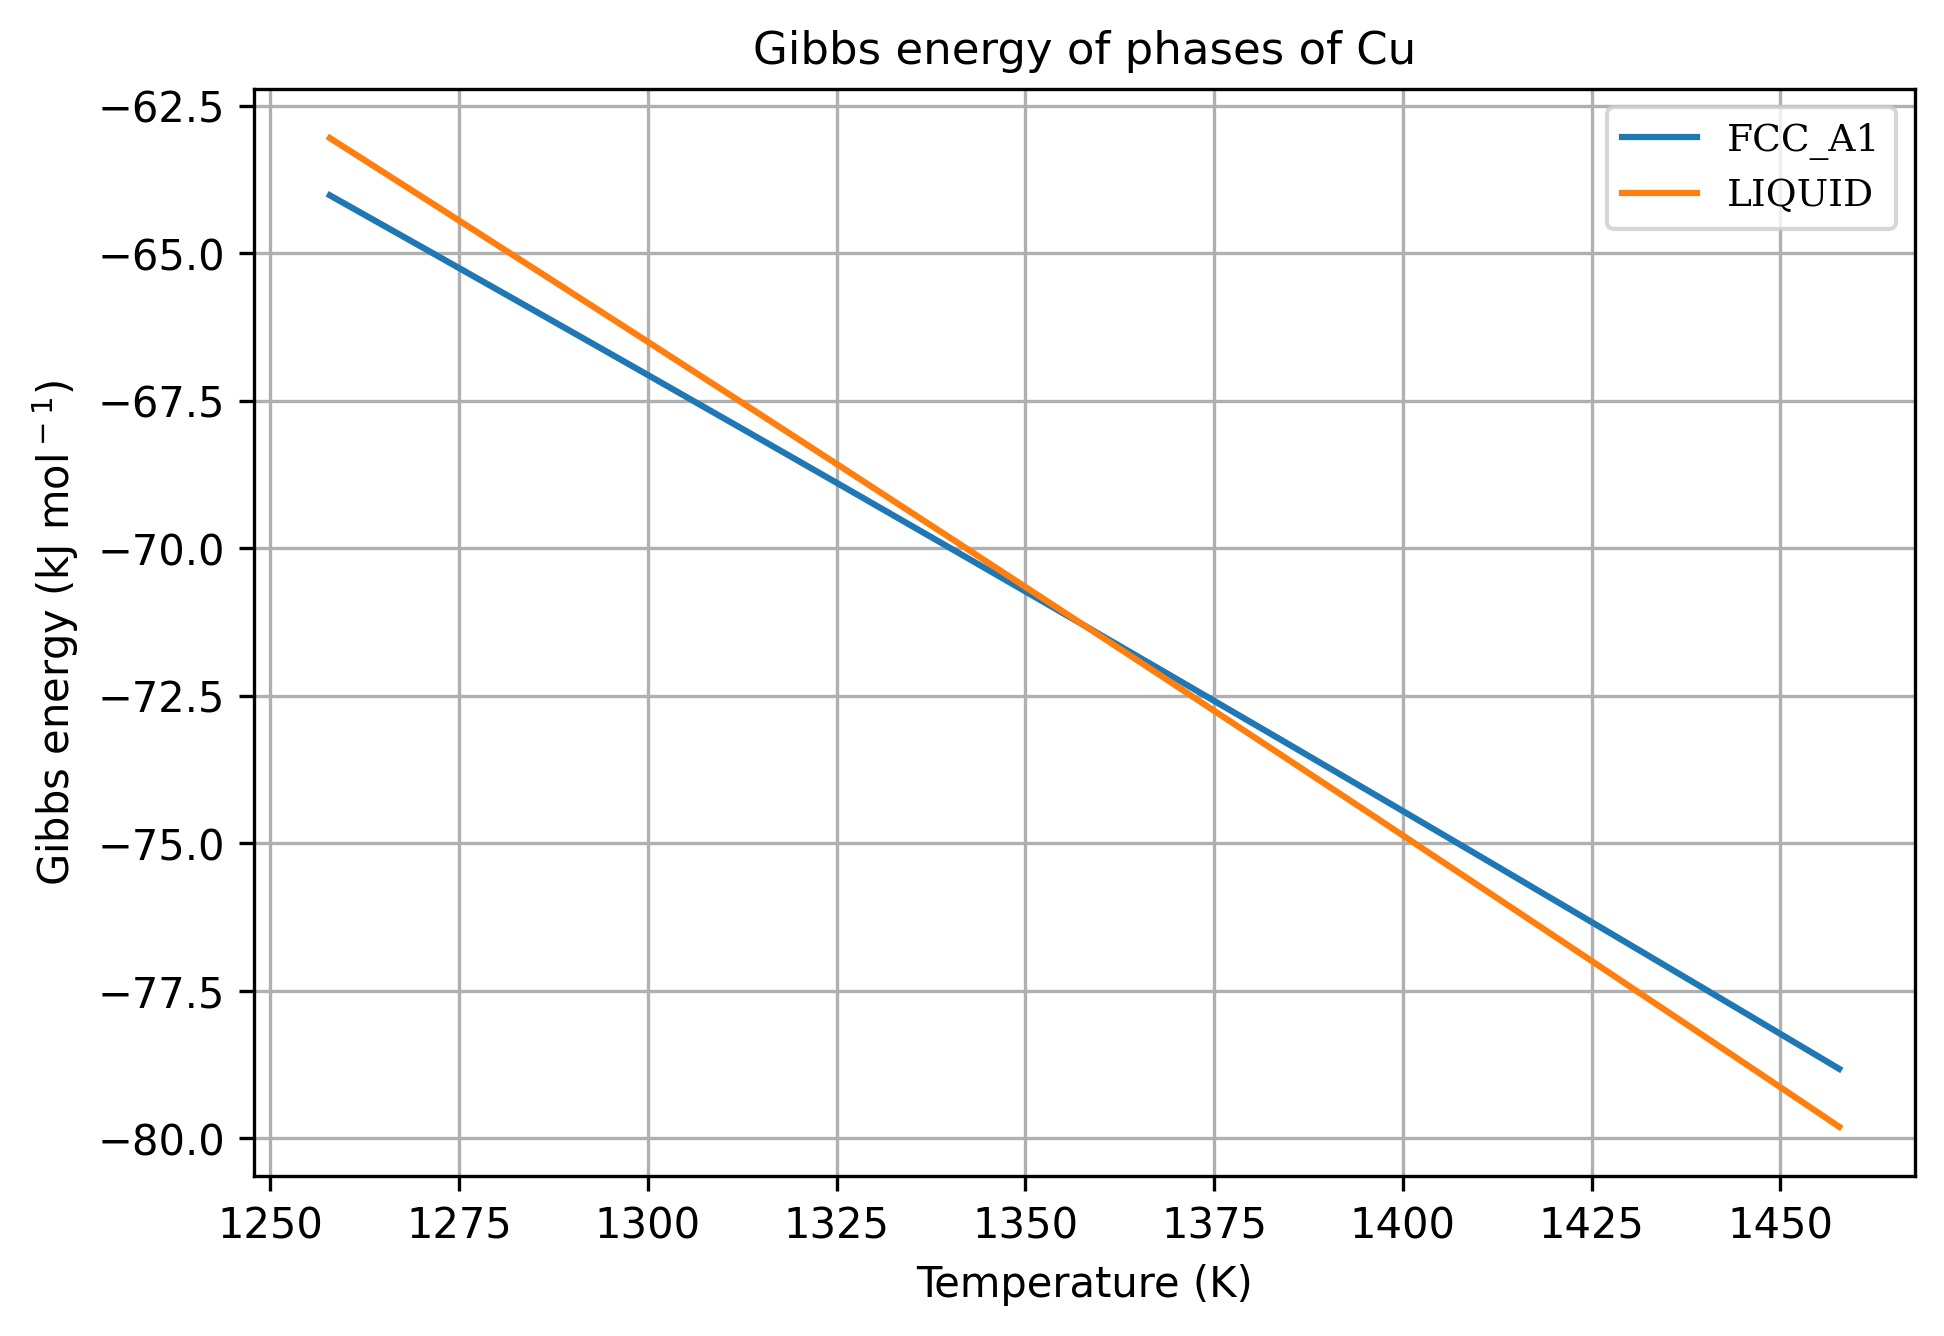

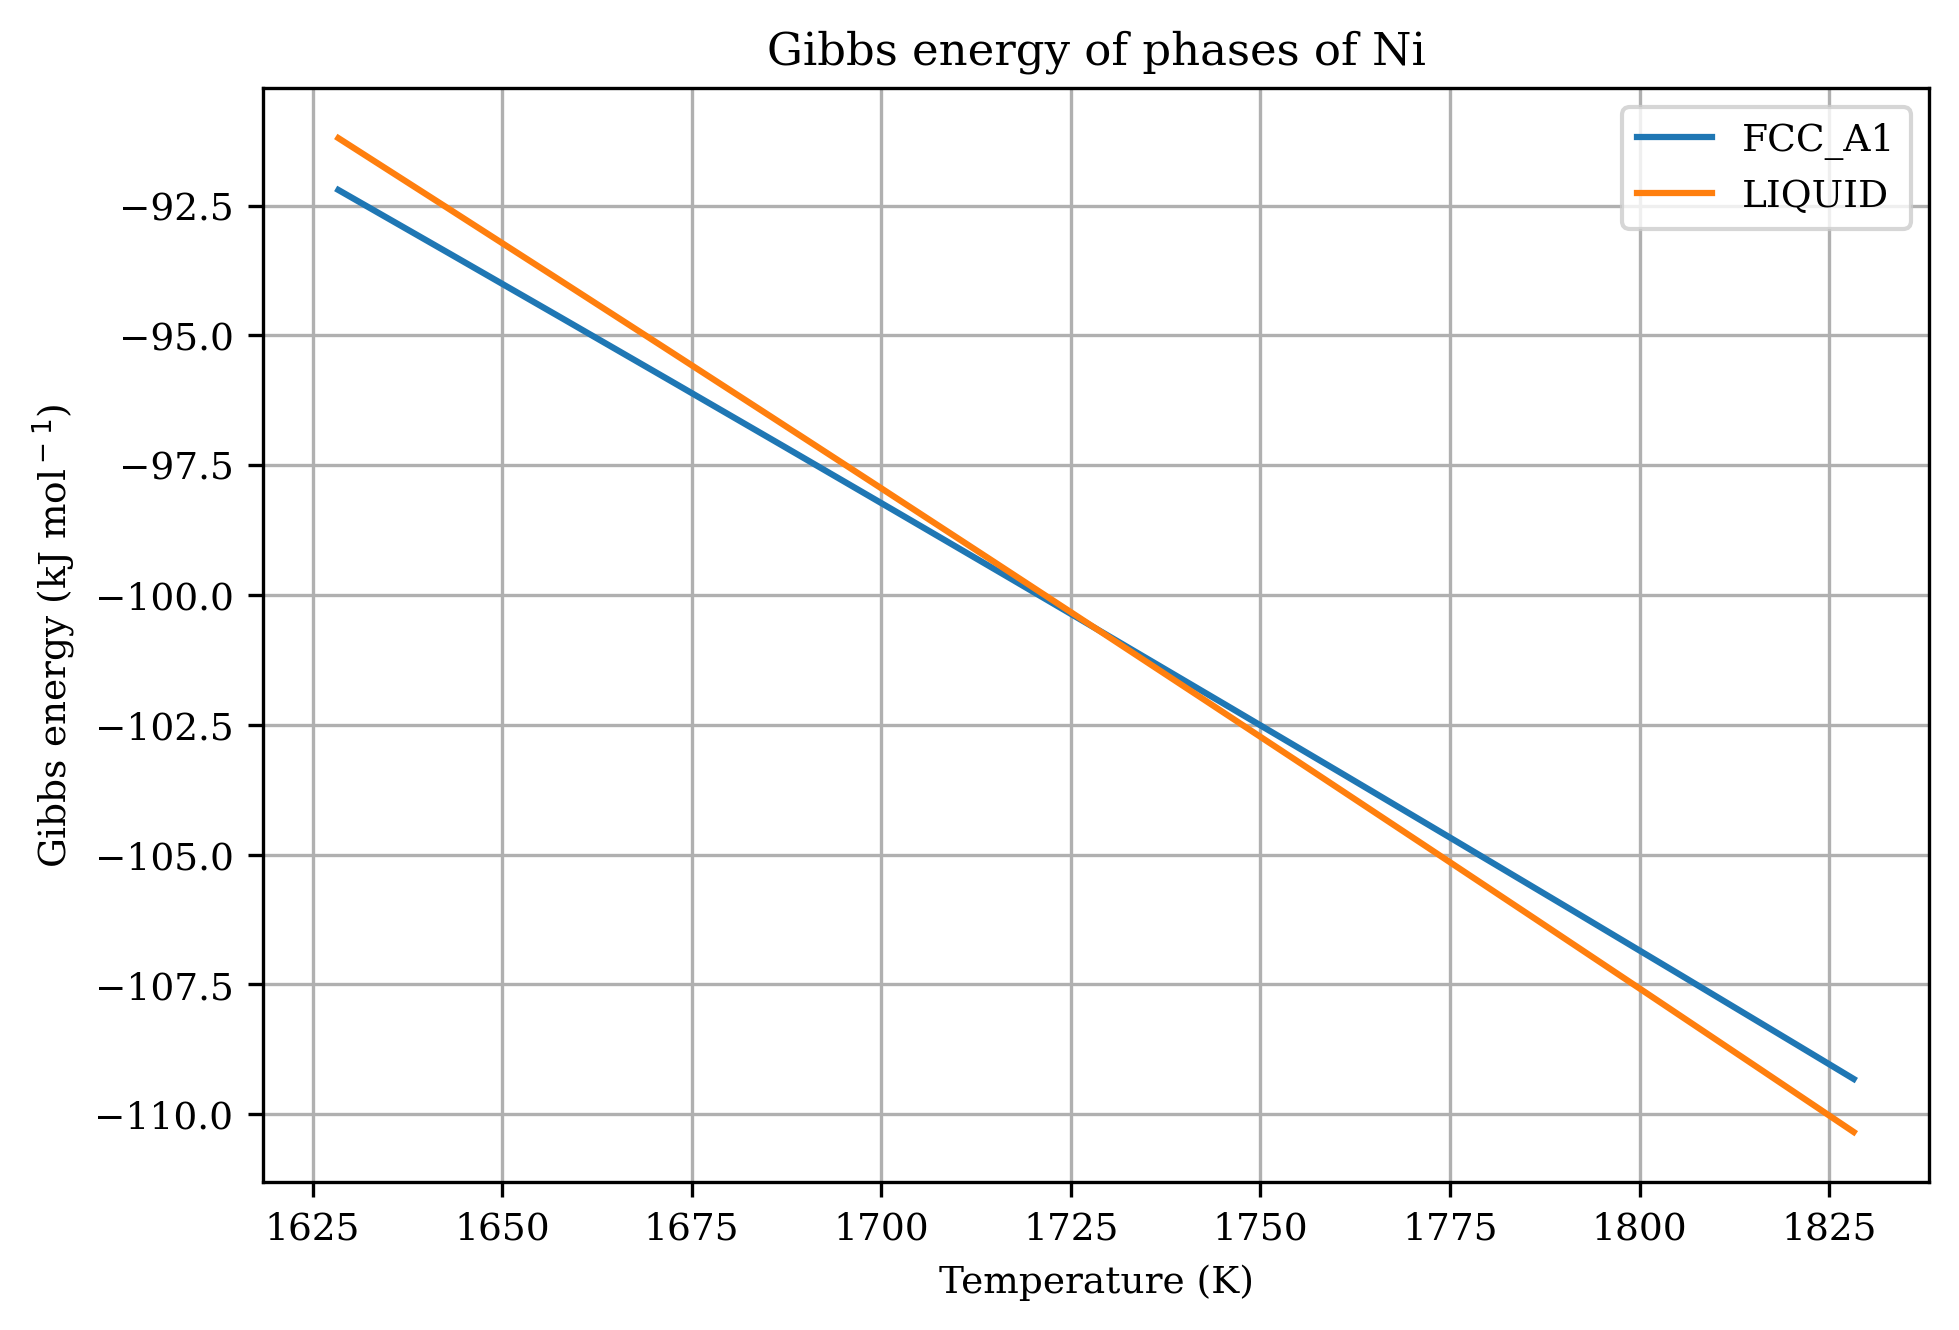

In [18]:
for element, temp_range in zip([cu_fcc_liquid, ni_fcc_liquid], [cu_temp_range, ni_temp_range]):
    g, t, ref = calc_thermoproperty_relative(element, None, "gibbs", temp_range)
    ax = plot_thermoproperty(element, g, t, ref, "gibbs")

By checking the plots we can see that, for both metals, there is a clear intersection between the FCC and liquid gibbs energies states. In the case of copper the curves cross each other around 1360K and for nickel around 1730 K, wich are very close than the values determined through employing *melting_temp* function. These temperatures should be indeed equal, as the gibbs energy equality is the central thermodynamic principle behind the algorithm contained in *melting_temp* function.

## **3.** For the same temperature intervals defined according to exercise 2, calculate and plot the molar enthalpy for solid and liquid phases of both metals (Cu and Ni), considering in each temperature interval only the most stable phase (FCC for temperatures lower than $T_{m}$ and Liquid for temperatures higher than $T_{m}$). Next, calculate the fusion molar enthalpy of the metals and compare the obtained values with the ones contained in Table 2.

In order calculate molar enthalpies, function can again be employed, but, this time, the name of the desired property (*prop*) in call of function *calc_thermoproperty_relative* must be changed from *gibbs* to *enthalpy*. After computing the desired molar enthalpy values for both liquid and solid phases, the respective plots can be performed, as in exercise 2, through use of function *plot_thermoproperty*.

In order to plot the molar enthalpy of each phase only in temperature interval, where it is thermodynamicaly stable, specific temperature vectors must be defined for the solid and liquid phases, as shown bellow. The solid is stable for temperature lower than the determined $T_{m}$ and liquid above.

In [19]:
cu_temp_range_fcc = [cu_tm - 100, cu_tm]
cu_temp_range_liquid = [cu_tm, cu_tm + 100]

ni_temp_range_fcc = [ni_tm - 100, ni_tm]
ni_temp_range_liquid = [ni_tm, ni_tm + 100]

Wirh the temperature vectors defined for each phase, their molar enthapies can be computed through use of *calc_thermoproperty_relative*.

In [20]:
g_cu_list = []
t_cu_list = []
g_ni_list = []
t_ni_list = []

for temp_range in [cu_temp_range_fcc, cu_temp_range_liquid]:
    g, t, ref = calc_thermoproperty_relative(cu_fcc_liquid, None, "enthalpy", temp_range)
    g_cu_list.append(g)
    t_cu_list.append(t)

for temp_range in [ni_temp_range_fcc, ni_temp_range_liquid]:
    g, t, ref = calc_thermoproperty_relative(ni_fcc_liquid, None, "enthalpy", temp_range)
    g_ni_list.append(g)
    t_ni_list.append(t)

Finally, the molar enthalpies can be ploted for latter use in the quantitative evaluation of the respective funsion enthalpies.

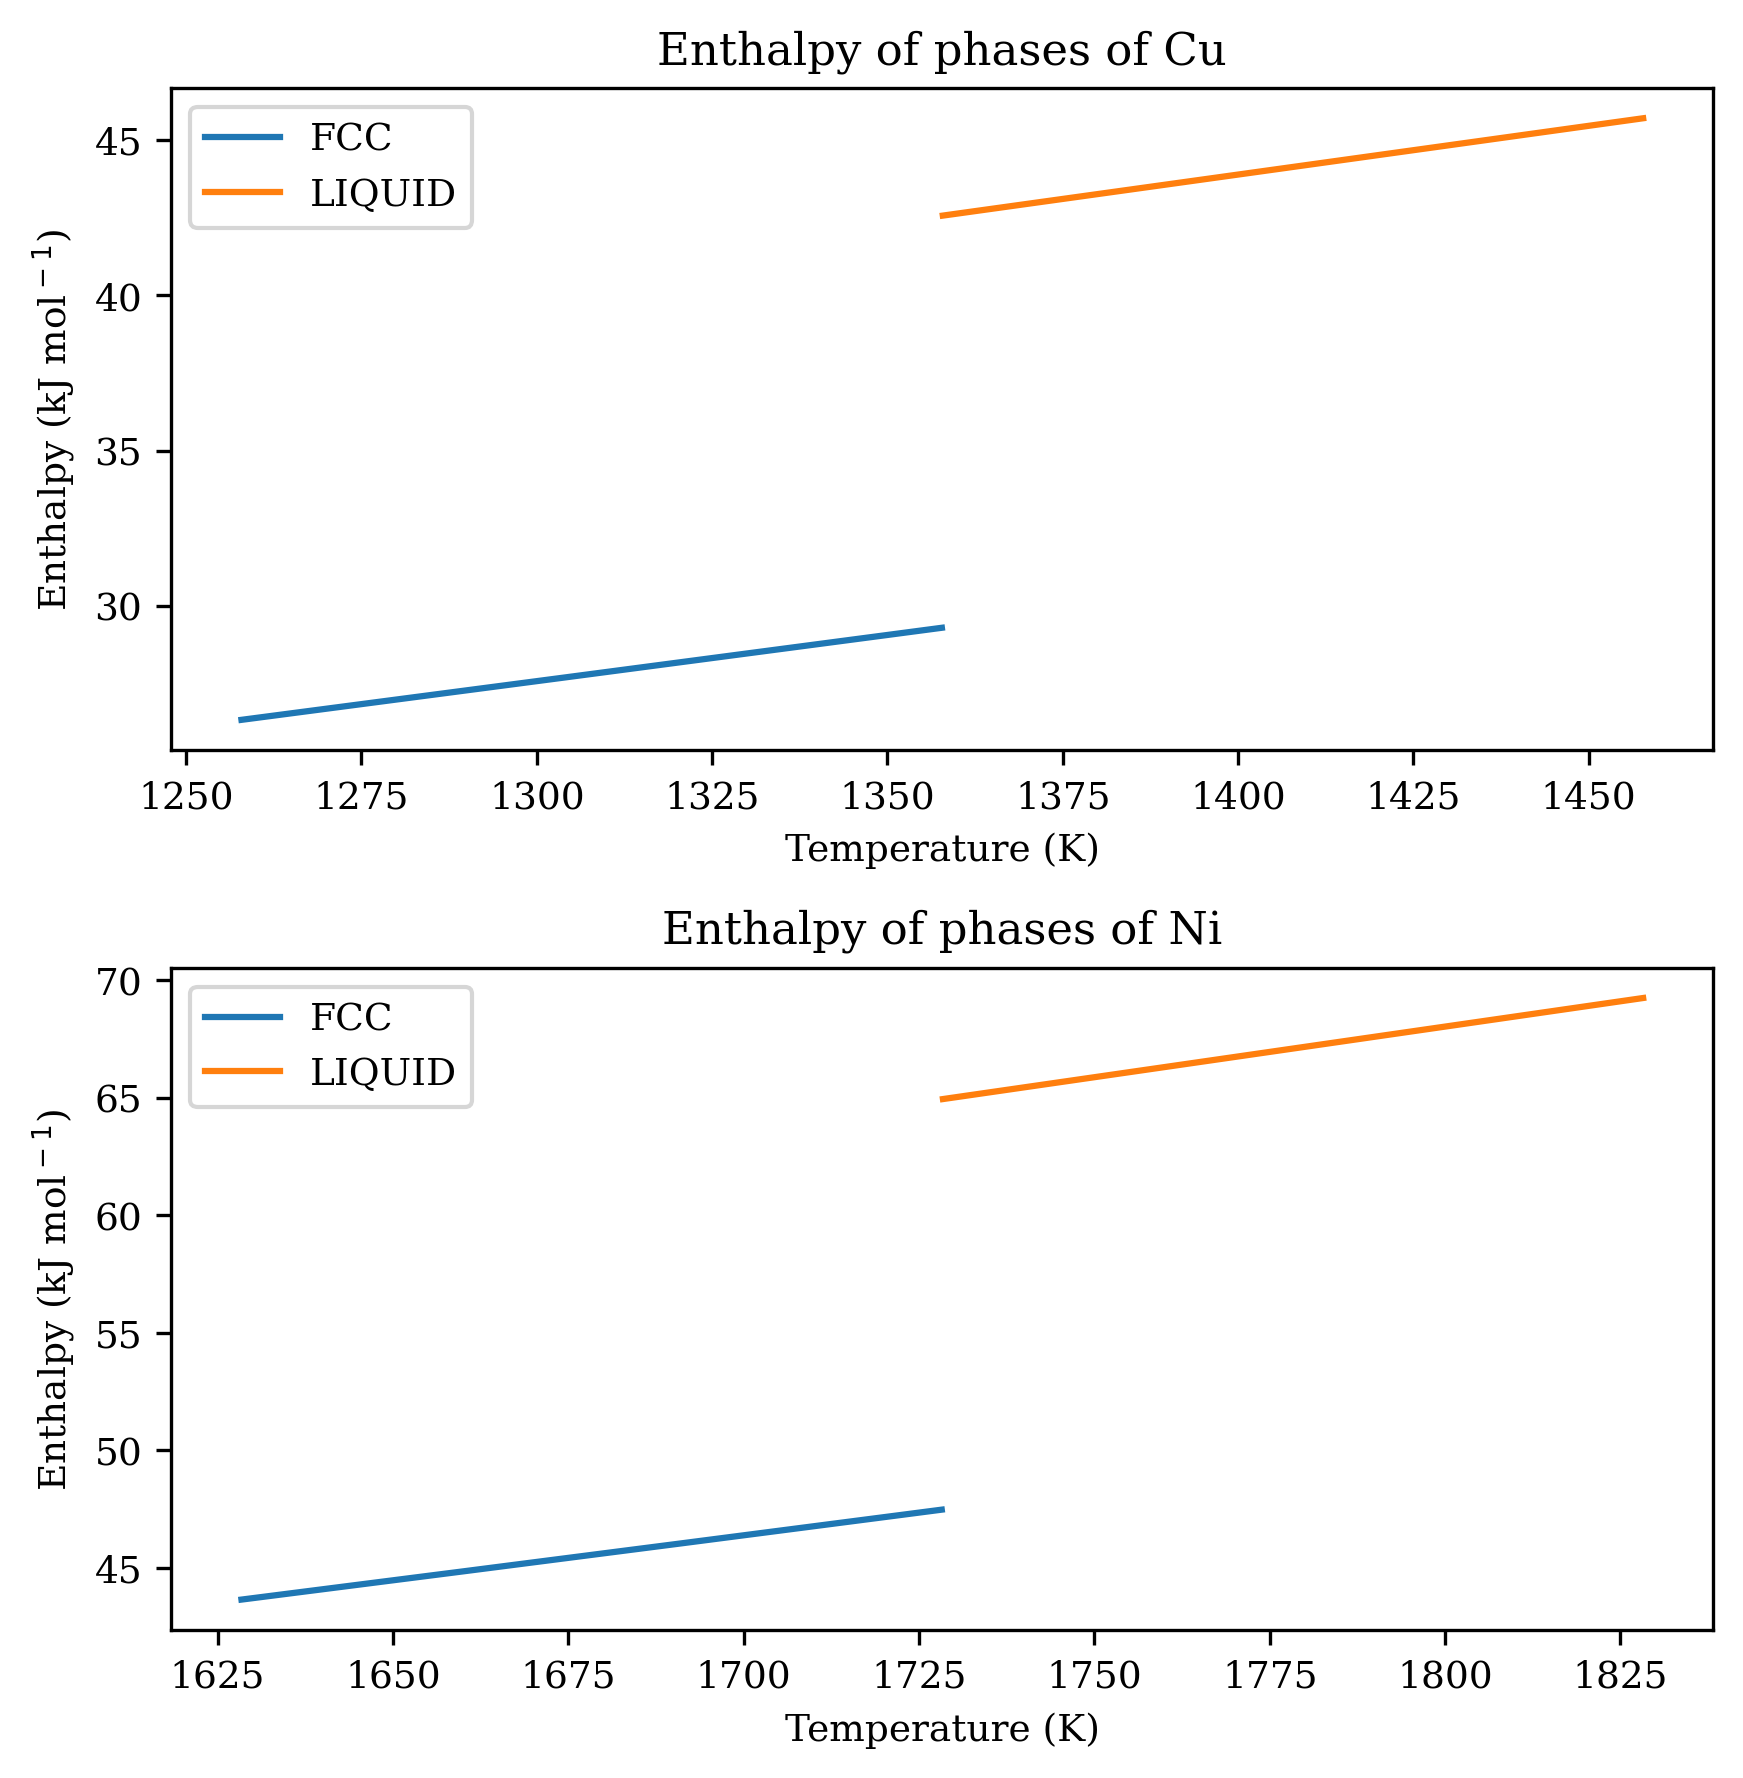

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6), dpi = 300)
plt.rcParams['font.family'] = 'Serif'
plt.rcParams.update({'font.size': 9})

ax1.plot(t_cu_list[0][0], g_cu_list[0][0], label = "FCC")
ax1.plot(t_cu_list[1][1], g_cu_list[1][1], label = "LIQUID")
ax2.plot(t_ni_list[0][0], g_ni_list[0][0], label = "FCC")
ax2.plot(t_ni_list[1][1], g_ni_list[1][1], label = "LIQUID")

ax1.set_title("Enthalpy of phases of Cu")
ax2.set_title("Enthalpy of phases of Ni")


for ax in [ax1, ax2]:
    ax.legend()
    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Enthalpy (kJ mol${^-}{^1}$)")
    fig.tight_layout()

It is seen, that for both metals there is a discontinuity at the melting point, which is actually the molar energy, which is necessary to brake the long distance order in FCC phase leading to the liquid state.

In [22]:
h_cu_fcc = calc_thermofunctions(cu_fcc, cu_tm, "enthalpy")
h_cu_liquid = calc_thermofunctions(cu_liquid, cu_tm, "enthalpy")

h_ni_fcc = calc_thermofunctions(ni_fcc, ni_tm, "enthalpy")
h_ni_liquid = calc_thermofunctions(ni_liquid, ni_tm, "enthalpy")

In order to quantitative calculate the molar enthalpy of fusion of both metals involved, the molar enthapies of both phases at $T_{m}$ must be previously determined, and the desired molar enthalpies then determined through the differences of the values found. To get the values in J/g (unit from data of Table 2) we must divide them by the respective atomic mass.

In [51]:
print(f"Molar enthalpy of fusion of Cu: {-h_cu_fcc + h_cu_liquid:.1f} J/mol")
print(f"Molar enthalpy of fusion of Ni: {-h_ni_fcc + h_ni_liquid:.1f} J/mol")

Molar enthalpy of fusion of Cu: 13263.3 J/mol
Molar enthalpy of fusion of Ni: 17472.7 J/mol


Through a comparison with data from Table 2 is evident that there is a very good agreeement between experimental and calculated values, with deviations inside each confidence interval. In order to achieve a quantitative view of the deviations, both absolute and relative deviations can be computed.

In [52]:
print(f"Cu: {abs(13.3-13.1):.1f} J/g, relative error: {100*abs(13.3-13.1)/13.1:.3f}%          Ni: {abs(17.5-17.2)} J/g, relative error: {100*abs(17.5-17.2)/17.2:.3f}%")

Cu: 0.2 J/g, relative error: 1.527%          Ni: 0.3000000000000007 J/g, relative error: 1.744%


As observed, very low deviations were observed, corroborating the accuracy of the SSOL2 parameters for computing the molar Gibbs energies of copper and nickel.

## **4.** For the same temperature range considered in exercise 2, plot the molar entropy of both pure metals, considering in each temperature interval only the most stable phase (FCC for temperatures lower than $T_{m}$ and Liquid for temperatures higher than $T_{m}$). Next, evaluate graphicaly the fusion molar entropies of copper and nickel.


In order to calculate the molar entropy, the same procedure as employed in exercise 3 can be applied, and in call of *calc_thermoproperty_relative* function *prop* name should be set equal to *entropy*.

In [26]:
g_cu_list = []
t_cu_list = []
g_ni_list = []
t_ni_list = []

for temp_range in [cu_temp_range_fcc, cu_temp_range_liquid]:
    g, t, ref = calc_thermoproperty_relative(cu_fcc_liquid, None, "entropy", temp_range)
    g_cu_list.append(g)
    t_cu_list.append(t)

for temp_range in [ni_temp_range_fcc, ni_temp_range_liquid]:
    g, t, ref = calc_thermoproperty_relative(ni_fcc_liquid, None, "entropy", temp_range)
    g_ni_list.append(g)
    t_ni_list.append(t)

Finally, the molar entropies of each phase can be ploted, as performed earlier for enthalpy.

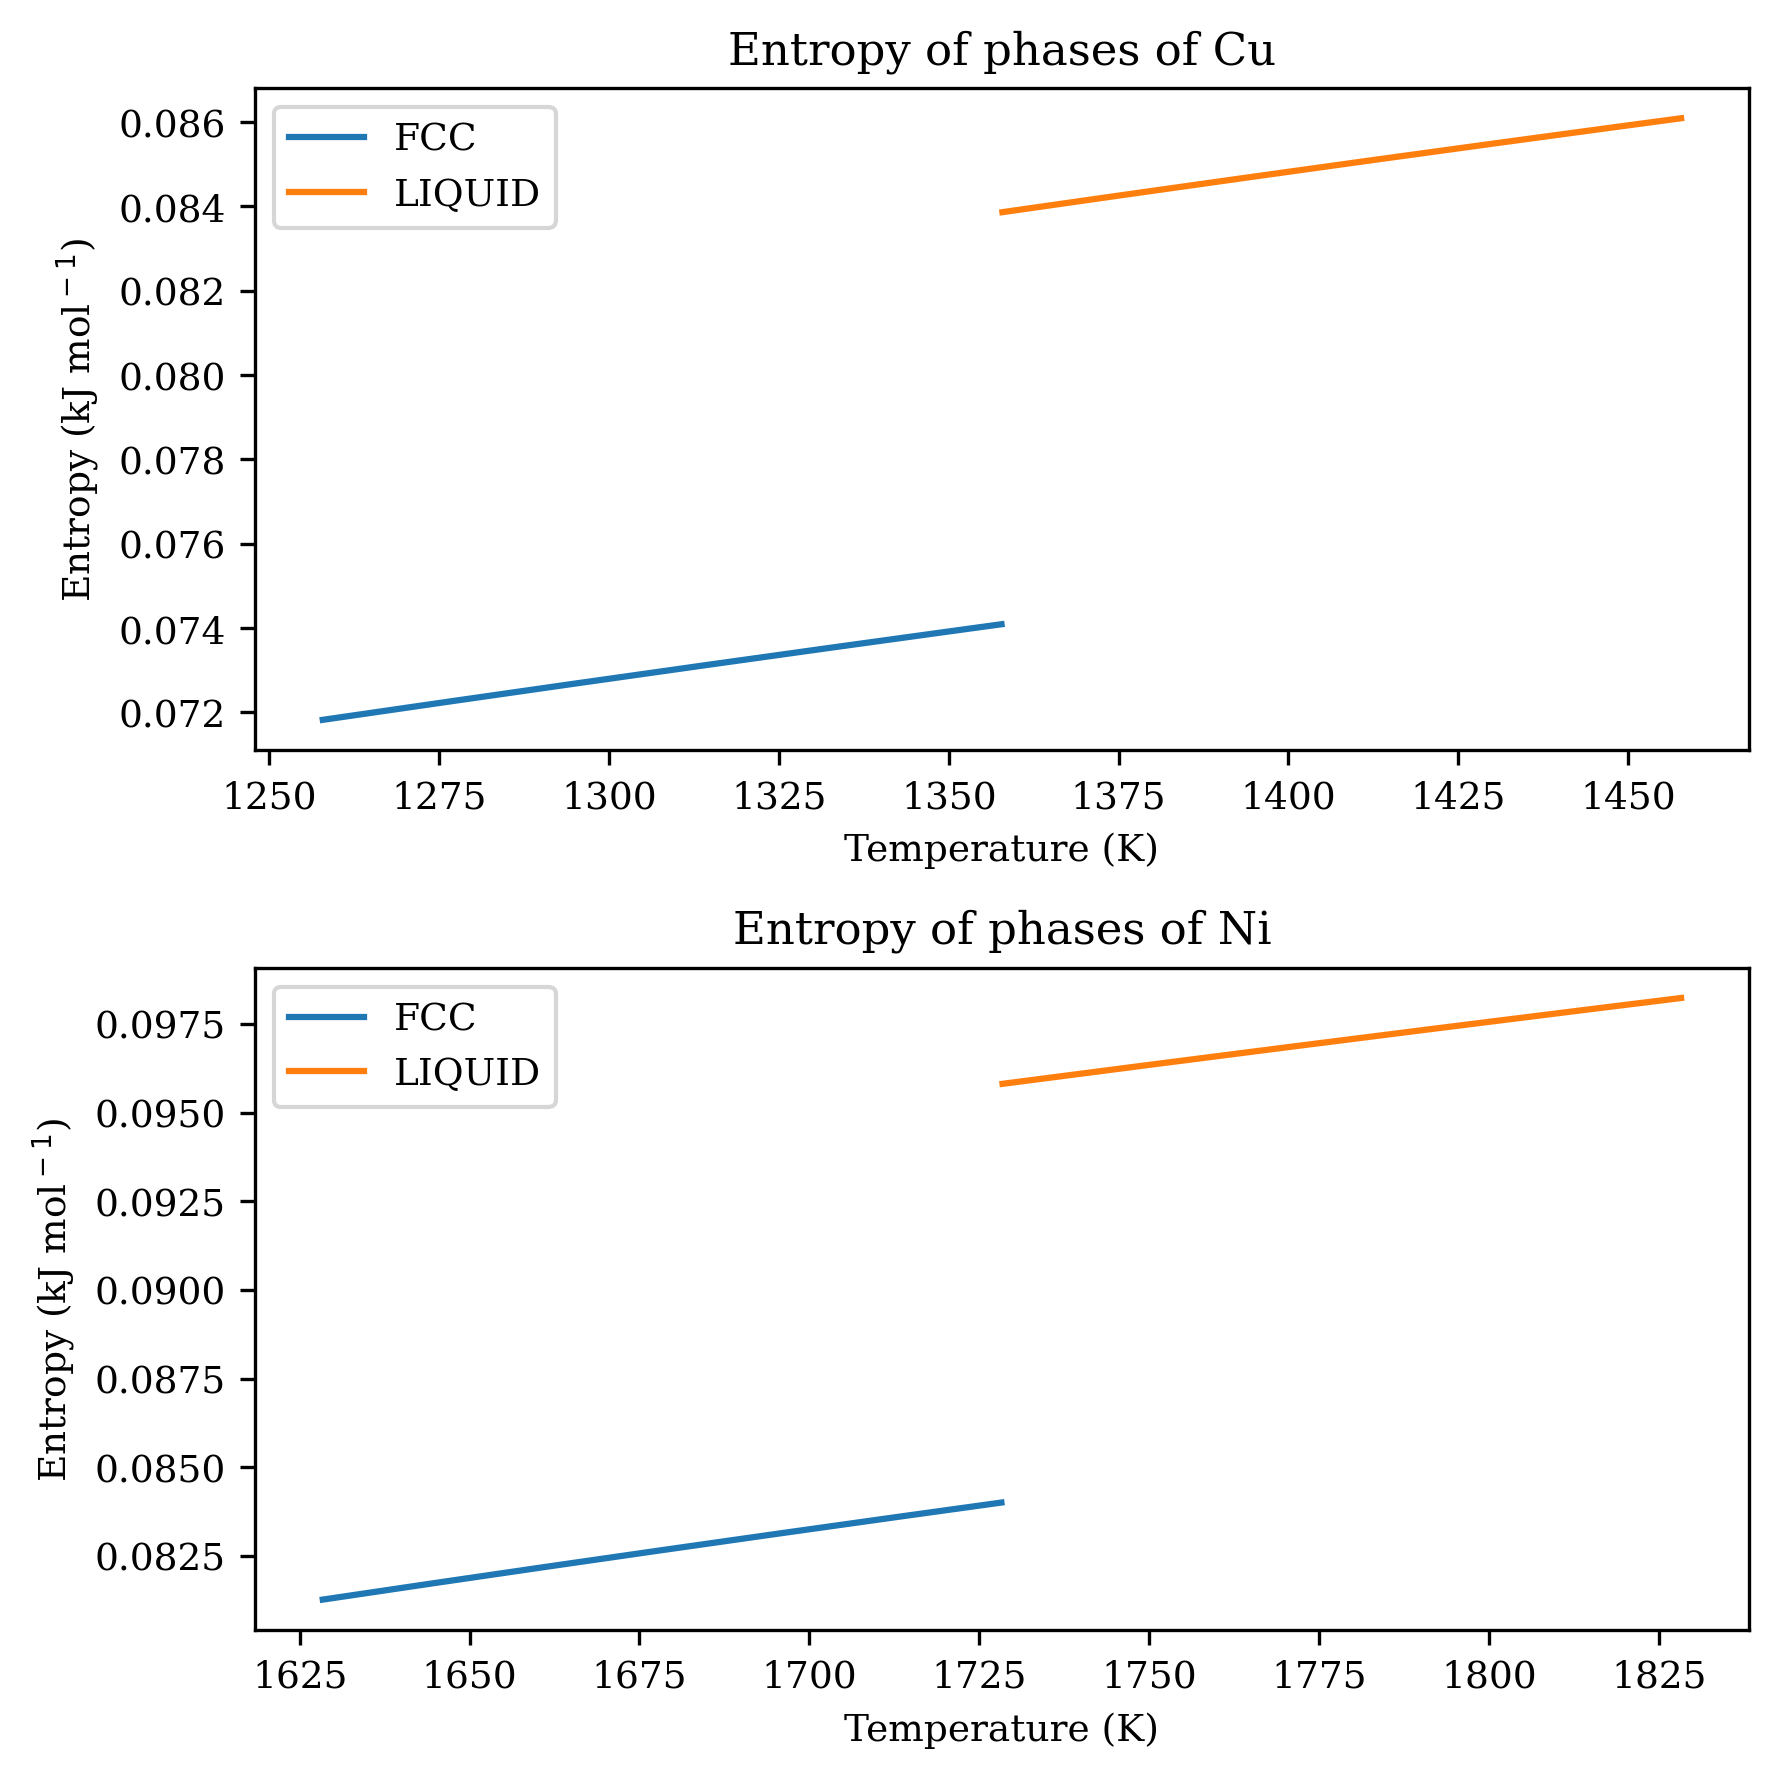

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6), dpi = 300)
plt.rcParams['font.family'] = 'Serif'
plt.rcParams.update({'font.size': 9})

ax1.plot(t_cu_list[0][0], g_cu_list[0][0], label = "FCC")
ax1.plot(t_cu_list[1][1], g_cu_list[1][1], label = "LIQUID")
ax2.plot(t_ni_list[0][0], g_ni_list[0][0], label = "FCC")
ax2.plot(t_ni_list[1][1], g_ni_list[1][1], label = "LIQUID")

ax1.set_title("Entropy of phases of Cu")
ax2.set_title("Entropy of phases of Ni")

for ax in [ax1, ax2]:
    ax.legend()
    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Entropy (kJ mol${^-}{^1}$)")
    fig.tight_layout()

As in the case of enthalpy, the molar entropy also shows a prominent discontinuity at the melting point. The respective molar entropies at $T_{m}$ are next computed.

In [28]:
s_cu_fcc = calc_thermofunctions(cu_fcc, cu_tm, "entropy")
s_cu_liquid = calc_thermofunctions(cu_liquid, cu_tm, "entropy")

s_ni_fcc = calc_thermofunctions(ni_fcc, ni_tm, "entropy")
s_ni_liquid = calc_thermofunctions(ni_liquid, ni_tm, "entropy")

Finally, we subtract the molar entropies of the solid from the liquid values to get the molar entropy of fusion for each metal, which is computed in $J.mol^{-1}K^{-1}$.

In [53]:
print(f"Molar entropy of fusion of Cu: {-s_cu_fcc + s_cu_liquid:.3f} J/mol.K")
print(f"Molar entropy of fusion of Ni: {-s_ni_fcc + s_ni_liquid:.3f} J/mol.K")

Molar entropy of fusion of Cu: 9.768 J/mol.K
Molar entropy of fusion of Ni: 11.803 J/mol.K


## **5.** Employing the melting temperatures and molar enthalpies ($\Delta H_{m}$) determined before, calculate the molar entropies ($\Delta S_{m}$) based on equation (1) and compare the results with values determined graphically in exercise 4.
$\Delta S_{m}=\Delta H_{m} /T_{m}$ (1).

Using the equation 1, together with values for $\Delta H_{m}$ and $T_{m}$ obtained before, a very similar value of $\Delta S_{m}$ was obtained for copper, with a relative error of 0.26%. In the case of nickel, however, a much higher difference was observed, with a relative error of 14.2%, suggesting that the data-base shoud revised for this element, in order to enhance accuracy.

In [58]:
cu_fusion_entropy = 1000*13.3/cu_tm #J/mol.K
ni_fusion_entropy = 1000*17.5/ni_tm #J/mol.K
print(f"Cu: Relative error: {100*abs(cu_fusion_entropy-9.77)/9.77:.3f}% Ni: Relative error: {100*abs(ni_fusion_entropy-11.8)/11.8:.3f}%")

Cu: Relative error: 0.261% Ni: Relative error: 14.187%


# **List 2 - Cu-Ni alloy liquid - solid phase equilibrium**

## **Some functions and variable definitions**

For computing liquid - solid equilibrium some variables must be previously defined, as shown bellow. These are needed for use of *equilibrium_composition* function, which calculates the liquidus temperature and FCC phase composition in equilibrium.

In [31]:
melt_temps = [1358., 1728.] #Cu and Ni melting temperatures
elements = [copper, nickel] #Cu and Ni full gibbs energy data
states = ["FCC_A1", "LIQUID"] #Cu and Ni states we are interested in

In order to construct the plots required some functions for definition of secondary axes were created.

In [32]:
#secondary axises needed for the phase diagram
def metal(x_theoretical):
    return x_theoretical

def metal2(x_theoretical):
    return 1 - x_theoretical

def temp_kelvin(temp_theoretical):
    return temp_theoretical

def temp_celsius(temp_theoretical):
    return -273.15 + temp_theoretical

## **1.** Plot the Cu - Ni phase diagram at 1 atm in temperature – composition space (T - z). During the computation, assume that both the liquid and solid phases behave like ideal solutions. Also, determine temperature range in which both solid (FCC) and liquid phases can be both found at thermodynamic equilibrium for an alloy containing 30% of Ni.

IN order to treat both solutions (liquid and FCC) as ideal solutions, values of Ln parameters (sub-regular interaction parameters) must be set equal to zero.

In [33]:
L_solid_Cu_Ni = np.zeros((2,2))
L_liquid_Cu_Ni = np.zeros((2,2))

Next, Cu - Ni phase diagram is constructed with the aid of *equilibrium_composition* function.

In [34]:
n = 1000       #number of composition values
x_initial = 0.0000001       #minimum composition
x_final = 0.9999999         #maximum composition

z_theoretical = np.linspace(x_initial, x_final, n) #liquidus composition
temp_theoretical = np.zeros(n) #temperature to be calculated
x_theoretical = np.zeros(n) #solidus composition to be calculated

for k in range(n):
    [xs, temp_theoretical[k]] = equilibrium_composition(z_theoretical[k], melt_temps, elements, states, L_solid_Cu_Ni, L_liquid_Cu_Ni)
    x_theoretical[k] = xs[0]

Finally, the phase behavior can be graphically presented in the T - z (global composition) space.

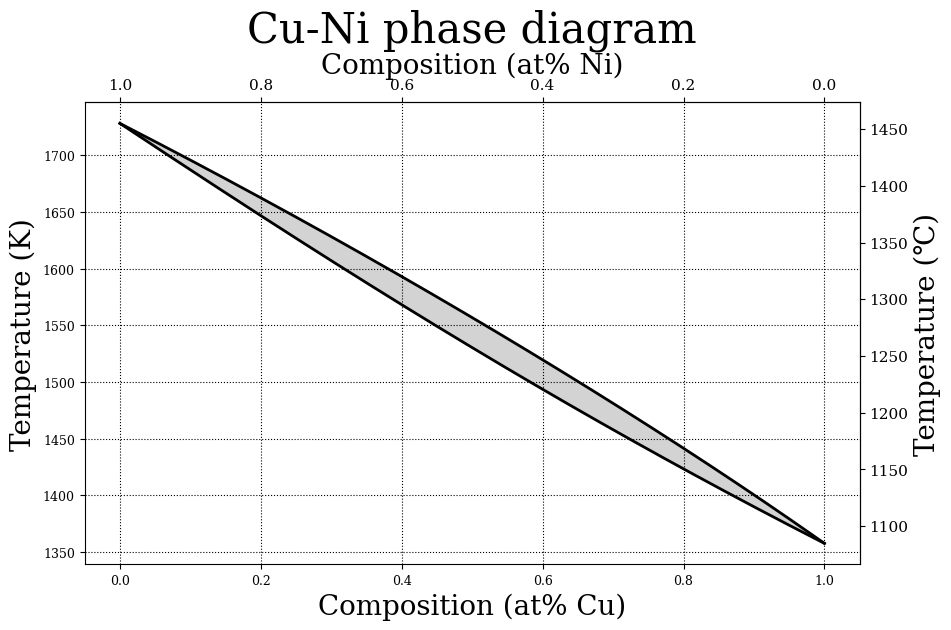

In [35]:
metal1_name = "Cu"
metal2_name = "Ni"
fig, ax = plt.subplots(figsize=(10,6), dpi = 100)
plt.rcParams.update({'font.size':11})

ax.plot(z_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "liquidus")
ax.plot(x_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "solidus")
ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical >= z_theoretical, facecolor = 'lightgrey')
ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical <= z_theoretical, facecolor = 'lightgrey')

ax.set_xlabel(f"Composition (at% {metal1_name})",fontsize = 20)
ax.set_ylabel('Temperature (K)',fontsize = 20)
ax.set_title(f"{metal1_name}-{metal2_name} phase diagram", fontsize = 30)

secax_x = ax.secondary_xaxis('top', functions =( metal, metal2 ))
secax_x.set_xlabel(f"Composition (at% {metal2_name})", fontsize = 20)

secax_y = ax.secondary_yaxis('right', functions = ( temp_celsius, temp_kelvin ))
secax_y.set_ylabel('Temperature (\u2103)', fontsize = 20)

plt.grid(True, color='k', linestyle=':')

The diagram depicted has an isomorph aspect, which is typicall from alloys, where elements involved do not show very appreciable differences among their physical properties.

Next, we need to find the temperatures at which we can find an alloy containing 30% of Ni. There are many pythonic ways of doing it. One such way is to find the index of the value in the z_theoretical (liquidus line composition) which is the closest to 0.3 of Ni by using the *min* function. Once we find this index we can match it on the temp_theoretical list to find the temperatures related to the condition of 0.3 of Ni, or, equivalently, 0.7 of Cu.

In [36]:
a = min(range(len(z_theoretical)), key=lambda i: abs(z_theoretical[i]-0.7)) #liquidus line
b = min(range(len(z_theoretical)), key=lambda i: abs(x_theoretical[i]-0.7)) #solidus line

max_temp = temp_theoretical[a]
min_temp = temp_theoretical[b]

print(f"the temperature range at which an ideal mixture of Cu-Ni contains 30% of Ni is [{min_temp:.2f} , {max_temp:.2f}] K")

the temperature range at which an ideal mixture of Cu-Ni contains 30% of Ni is [1458.19 , 1481.44] K


Using python built-in functions it is possible to precisely identify the temperature range in T-z diagram, where liquid and solid can coexist in equilibrium.

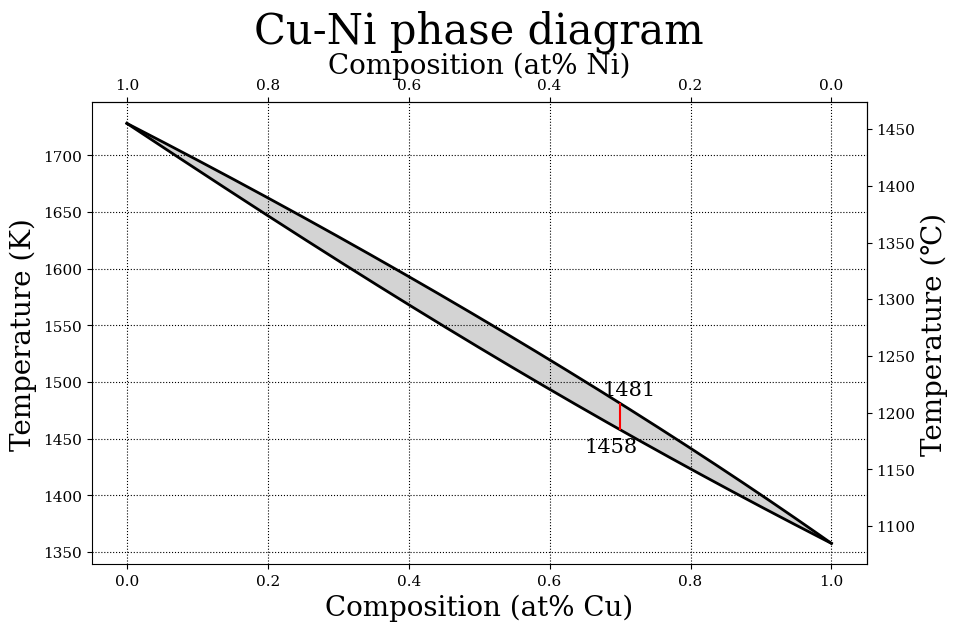

In [37]:
fig, ax = plt.subplots(figsize=(10,6), dpi = 100)
plt.rcParams.update({'font.size':11})
ax.plot(z_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "liquidus")
ax.plot(x_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "solidus")
plt.vlines(0.7, min_temp, max_temp, color = "red") #plotting the line

plt.text(0.65, min_temp-20, str( int( min_temp) ), horizontalalignment='left', fontsize = 15)
plt.text(0.75, max_temp+20, str( int( max_temp) ), horizontalalignment='right', verticalalignment = 'top', fontsize = 15)

ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical >= z_theoretical, facecolor = 'lightgrey')
ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical <= z_theoretical, facecolor = 'lightgrey')

ax.set_xlabel(f"Composition (at% {metal1_name})",fontsize = 20)
ax.set_ylabel('Temperature (K)',fontsize = 20)
ax.set_title(f"{metal1_name}-{metal2_name} phase diagram", fontsize = 30)

secax_x = ax.secondary_xaxis('top', functions =( metal, metal2 ))
secax_x.set_xlabel(f"Composition (at% {metal2_name})", fontsize = 20)

secax_y = ax.secondary_yaxis('right', functions = ( temp_celsius, temp_kelvin ))
secax_y.set_ylabel('Temperature (\u2103)', fontsize = 20)

plt.grid(True, color='k', linestyle=':')

## **2.** Now, considering that both liquid and solid phases behave as sub-regular solutions, recalculate the Cu-Ni phase-diagram and compare it with the one obtained in exercise 1.

For non-ideal solutions, proper values of Ln for liquid and solid solutions must first be loaded from associated text files.

In [38]:
L_solid_Cu_Ni = np.loadtxt("L_solid_Cu_Ni.txt")
L_liquid_Cu_Ni = np.loadtxt("L_liquid_Cu_Ni.txt")

Next, liquidus temperatures and FCC composition in equilibrium can be simultaneously computed through use of function *equilibrium_composition*.

In [39]:
n = 1000       #number of composition values
x_initial = 0.0000001       #minimum composition
x_final = 0.9999999         #maximum composition

z_theoretical = np.linspace(x_initial, x_final, n); #global composition vector (copper mol fraction)
temp_theoretical = np.zeros(n) #vector for storing temperature values
x_theoretical = np.zeros(n) #vector for storing FCC copper computed molar fraction values.

#Liquidus temperature and FCC
for k in range(n):
    [xs, temp_theoretical[k]] = equilibrium_composition(z_theoretical[k], melt_temps, elements, states, L_solid_Cu_Ni, L_liquid_Cu_Ni)

    x_theoretical[k] = xs[0]

Now, the associated T - z of no-ideal alloy can be plotted.

Text(0, 0.5, 'Temperature (℃)')

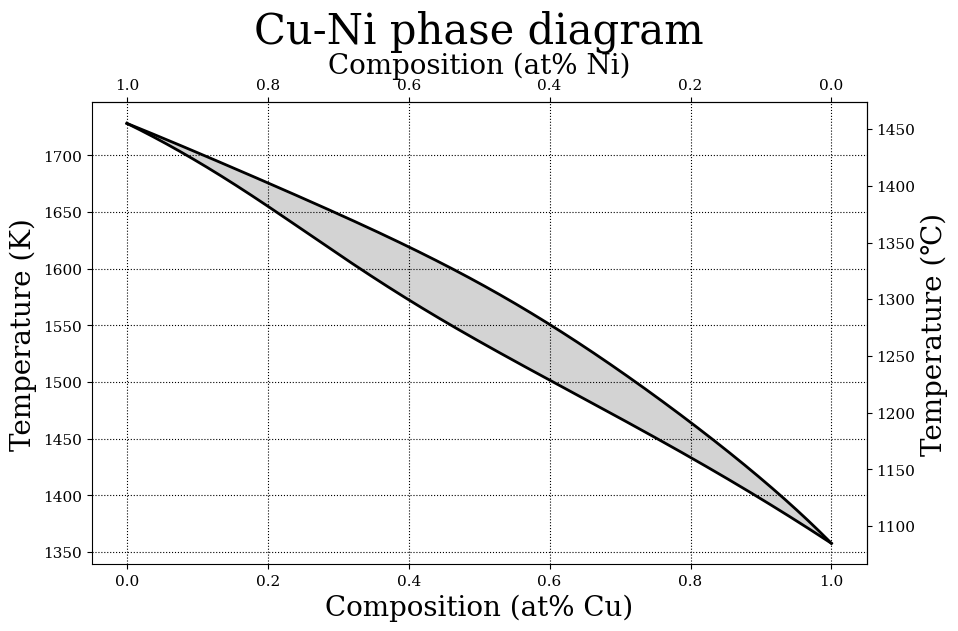

In [40]:
fig, ax = plt.subplots(figsize=(10,6), dpi = 100)
plt.rcParams.update({'font.size':11})
ax.plot(z_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "liquidus")
ax.plot(x_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "solidus")
plt.grid(True, color='k', linestyle=':')

ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical >= z_theoretical, facecolor = 'lightgrey')
ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical <= z_theoretical, facecolor = 'lightgrey')

ax.set_xlabel(f"Composition (at% {metal1_name})",fontsize = 20)
ax.set_ylabel('Temperature (K)',fontsize = 20)
ax.set_title(f"{metal1_name}-{metal2_name} phase diagram", fontsize = 30)

secax_x = ax.secondary_xaxis('top', functions =( metal, metal2 ))
secax_x.set_xlabel(f"Composition (at% {metal2_name})", fontsize = 20)

secax_y = ax.secondary_yaxis('right', functions = ( temp_celsius, temp_kelvin ))
secax_y.set_ylabel('Temperature (\u2103)', fontsize = 20)


As expected, the diagram for the non-ideal alloy is much different from the one calculated considered the Ln values equal to one (ideal condition). There is a significant symetry loss of solidus and liquidus lines. Also, the phase boundary shows an appreciable grownth, as depicted by the larger area, where liquid and solid phases can be simultaneously present in equilibrium.

## **3.** Based on the phase diagram plotted in exercise 2, evaluate, for an alloy containing 30% Ni, the temperature range at which both liquid and solid phases are present in equilibrium. Next, make a quantitative comparison with result based on phase diagram from exercise 1.


As performed before, using *min* function, it is possible to find in *temp_theoretical* vector the element (temperature value) associated with 0.7 copper mol fraction. In this way, the temperature limits for the two-phase boundary of the desired alloy can be  easily determined.

In [41]:
a = min(range(len(z_theoretical)), key=lambda i: abs(z_theoretical[i]-0.7)) #liquidus line
b = min(range(len(z_theoretical)), key=lambda i: abs(x_theoretical[i]-0.7)) #solidus line

max_temp = temp_theoretical[a]
min_temp = temp_theoretical[b]

print(f"the temperature range at which a subregular mixture of Cu-Ni contains 30% of Ni is [{min_temp:.2f} , {max_temp:.2f}]")

the temperature range at which a subregular mixture of Cu-Ni contains 30% of Ni is [1468.37 , 1509.88]


It can be observed that both limits changed appreciably in comparison with the ideal alloy, whose initial and final temperature values were respectively equal to 1458.19 and 1481.44 K.
The temperature range for the ideal mixture is [1458.19 , 1481.44]K and [1468.37 , 1509.88]K for the subregular mixture. We can see the limits are shifted upward due to the asymmetry of Cu and Ni atoms.

Finally, using python built-in functions it is possible to clarer depict the temperature interval, where both liquid and FCC phases can be found in equilibrium.

Text(0, 0.5, 'Temperature (℃)')

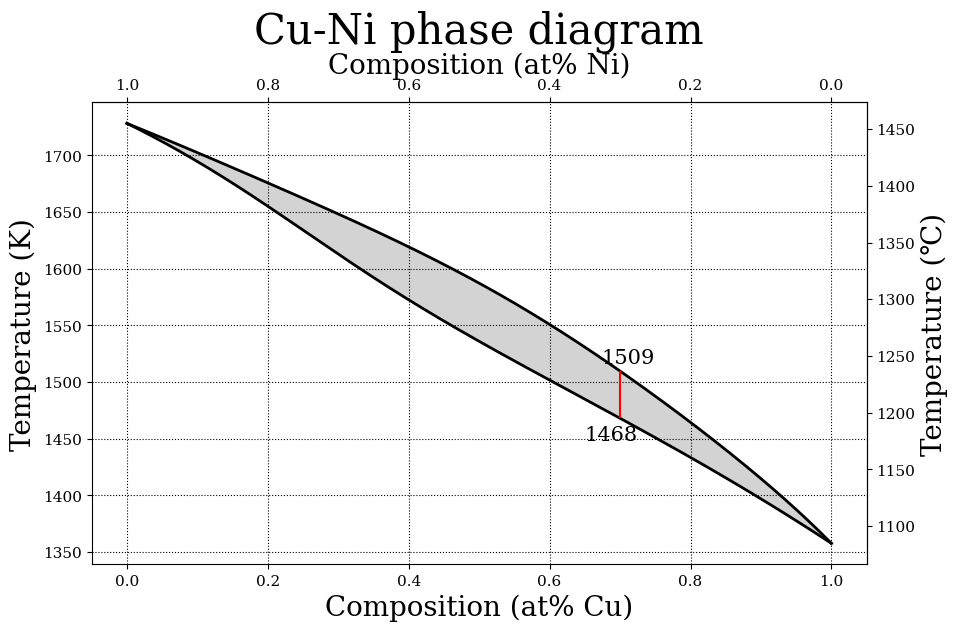

In [42]:
fig, ax = plt.subplots(figsize=(10,6), dpi = 100)
plt.rcParams.update({'font.size':11})
ax.plot(z_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "liquidus")
ax.plot(x_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "solidus")
plt.vlines(0.7, min_temp, max_temp, color = "red") #plotting the line
plt.grid(True, color='k', linestyle=':')
plt.text(0.65, min_temp-20, str( int( min_temp) ), horizontalalignment='left', fontsize = 15)
plt.text(0.75, max_temp+20, str( int( max_temp) ), horizontalalignment='right', verticalalignment = 'top', fontsize = 15)

ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical >= z_theoretical, facecolor = 'lightgrey')
ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical <= z_theoretical, facecolor = 'lightgrey')

ax.set_xlabel(f"Composition (at% {metal1_name})",fontsize = 20)
ax.set_ylabel('Temperature (K)',fontsize = 20)
ax.set_title(f"{metal1_name}-{metal2_name} phase diagram", fontsize = 30)


secax_x = ax.secondary_xaxis('top', functions =( metal, metal2 ))
secax_x.set_xlabel(f"Composition (at% {metal2_name})", fontsize = 20)

secax_y = ax.secondary_yaxis('right', functions = ( temp_celsius, temp_kelvin ))
secax_y.set_ylabel('Temperature (\u2103)', fontsize = 20)

## **4.** Based on the phase diagram plotted in exercise 3, predict the solubility limits for the liquid and solid phases, considering as equilibrium temperature the arithmetic mean of the pure metals melting points.

We need to find the liquid and solid equilibrium compositions at the temperature defined. For that we first find the position in the temp_theoretical list which best corresponds to the temperature. That position on the x_theoretical and z_theoretical lists gives us the compositions

In [43]:
temp = np.mean(melt_temps) #mean of copper and nickel melting temperatures.

c = min(range(len(temp_theoretical)), key=lambda i: abs(temp_theoretical[i]-temp)) #finding the position in the temp_theoretical vector that is equal to the mean temperature found previously

min_comp = x_theoretical[c] #solubility limit for the solid phase at the defined temperature
max_comp = z_theoretical[c] #solubility limit for the liquid phase at the defined temperature

print(f"the solubility limit at {temp:.0f}°C is {100*min_comp:.2f}% Cu in Ni for the FCC_A1 solid solution and {100 - 100*max_comp:.2f}% Ni in Cu for liquid solution")

the solubility limit at 1543°C is 47.97% Cu in Ni for the FCC_A1 solid solution and 38.04% Ni in Cu for liquid solution


Unging python built-in functions is possible to graphically depict the mol fraction ranges, where each phase (FCC or liquid) is present alone in equilibrium. The mol fraction range, where both phases are simulatenous expected is condiereably narrow, also a consequence from the fact that nickel and copper are metals with similar physical properties.

Text(0, 0.5, 'Temperature (℃)')

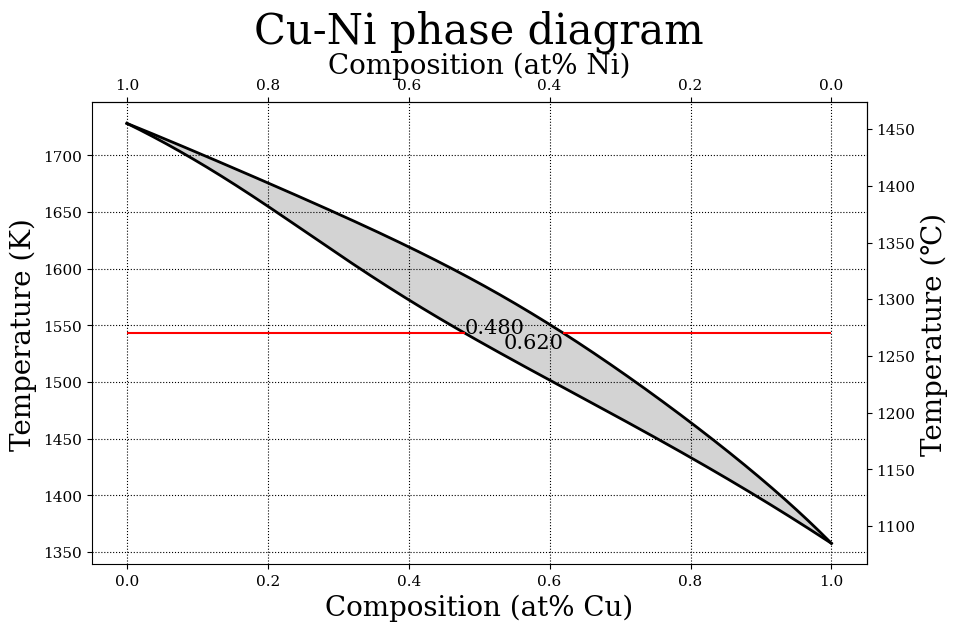

In [44]:
fig, ax = plt.subplots(figsize=(10,6), dpi = 100)
plt.rcParams.update({'font.size':11})
ax.plot(z_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "liquidus")
ax.plot(x_theoretical, temp_theoretical ,color = "black", linewidth = 2, label = "solidus")
plt.hlines(temp, 0, min_comp, color = "red")
plt.hlines(temp, max_comp, 1, color = "red")
plt.text(min_comp, temp, f"{min_comp:.3f}", horizontalalignment='left', fontsize = 15)
plt.text(max_comp, temp, f"{max_comp:.3f}", horizontalalignment='right', verticalalignment = 'top', fontsize = 15)
plt.grid(True, color='k', linestyle=':')

ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical >= z_theoretical, facecolor = 'lightgrey')
ax.fill_betweenx(temp_theoretical, x_theoretical, z_theoretical, where = x_theoretical <= z_theoretical, facecolor = 'lightgrey')

ax.set_xlabel(f"Composition (at% {metal1_name})",fontsize = 20)
ax.set_ylabel('Temperature (K)',fontsize = 20)
ax.set_title(f"{metal1_name}-{metal2_name} phase diagram", fontsize = 30)


secax_x = ax.secondary_xaxis('top', functions =( metal, metal2 ))
secax_x.set_xlabel(f"Composition (at% {metal2_name})", fontsize = 20)

secax_y = ax.secondary_yaxis('right', functions = ( temp_celsius, temp_kelvin ))
secax_y.set_ylabel('Temperature (\u2103)', fontsize = 20)

## **5.** Considering the solubility limits calculated in exercise 4, plot the activity coefficients of copper and nickel in liquid and FCC solutions as a function of molar fraction of copper and critically evaluate the obtained results (consider in each composition interval only the most thermodynamically stable phase).

First, we need to create composition vectors for each phase, considering the stability limits depicted on diagrama of exercise 4, as liquid is the only phase present in equilibrium for copper mol fractions higher than 0.62 and FCC phase for mol fractions lower than 0.48. Next, chemical activity coefficient values are computed for each composition range using *activity_coefficient* function previously defined.

In [45]:
#the solubility limit at 1543°C is 47.97% Cu in Ni for solid mixtures
solid_comp = np.linspace(0, min_comp, 1000)
solid_act_cu = []
solid_act_ni = []

for i in solid_comp:
    a = activity_coefficient(i, 1 - i, temp, L_solid_Cu_Ni) #calculating
    solid_act_cu.append(a[0])
    solid_act_ni.append(a[1])

In [46]:
#he solubility limit at 1543°C is 38.04% Ni in Cu for liquid mixtures
liquid_comp = np.linspace(max_comp, 1.0, 1000)
liquid_act_cu = []
liquid_act_ni = []

for i in liquid_comp:
    a = activity_coefficient(i, 1 - i, temp, L_liquid_Cu_Ni)
    liquid_act_cu.append(a[0])
    liquid_act_ni.append(a[1])

Finally, the desired plot can be constructed.

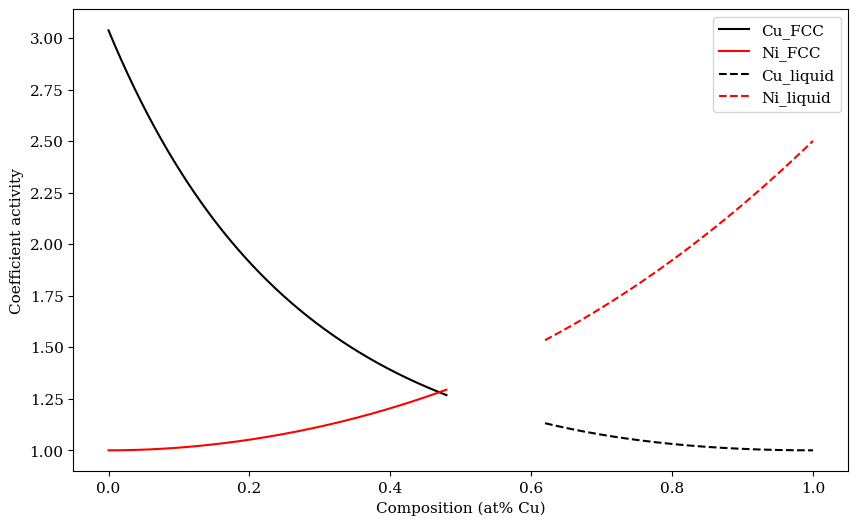

In [47]:
fig, ax = plt.subplots(figsize=(10,6), dpi = 100)
plt.rcParams.update({'font.size':11})
ax.plot(solid_comp, solid_act_cu ,color = "black", linewidth = 1.5, label = "Cu_FCC")
ax.plot(solid_comp, solid_act_ni ,color = "red", linewidth = 1.5, label = "Ni_FCC")

ax.plot(liquid_comp, liquid_act_cu ,color = "black", linewidth = 1.5, linestyle = "--", label = "Cu_liquid")
ax.plot(liquid_comp, liquid_act_ni ,color = "red", linewidth = 1.5, linestyle = "--", label = "Ni_liquid")

ax.set_xlabel(f"Composition (at% {metal1_name})")
ax.set_ylabel('Coefficient activity')
ax.legend()

As expected from classical thermodynamics, the activitiy coefficients must be equal to one, when the alloy becomes pure in one of the metals. It is interesting to bserve that for both metals and for both solutions considered, there is a positive deviation from ideality (activity coefficients higher than one), suggesting that molecular repulsion is the dominant mean molecular interaction.

## **6.** Considering equation 1 for calculating the molar fraction of solid ($\phi _{s}$)present in equilibrium for an alloy of global copper composition (z) and copper mol fractions in liquid and FCC phases respectively equal to $x_{l}$ and $x_{s}$, plot the mol fractions of liquid and FCC solutions in the two-phase region at the same temperature as considered in exercise 5.
$ \phi _{s}=(z-x_{l})/(x_{s}-x_{l})$ (1)

Let's define a function to calculate the FCC molar fraction.

In [48]:
def calc_molar_fraction(z, x_sol, x_liq):
    return (z - x_liq)/(x_sol - x_liq)

Applying equation 2 for a copper mol fraction range between 0.48 and 0.62 it is possible to calculate the molar fraction of FCC phase, and through the its difference from unity the molar fraction of liquid phase.

In [49]:
compositions = np.linspace(min_comp, max_comp, 1000)
frac_fcc = []
frac_liquid = []

for i in compositions:
    a = calc_molar_fraction(i, min_comp, max_comp)
    frac_fcc.append(a)
    frac_liquid.append(1 - a)

Finally, the desired plot can be constructed.

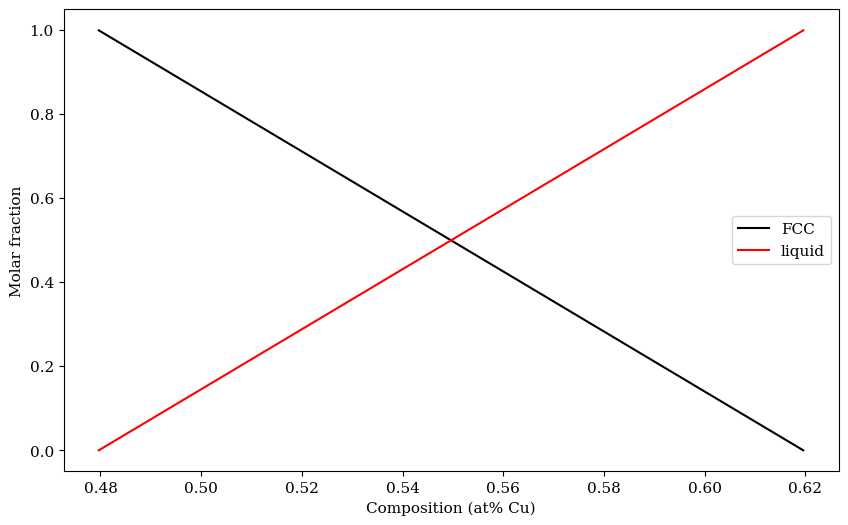

In [50]:
fig, ax = plt.subplots(figsize=(10,6), dpi = 100)
plt.rcParams.update({'font.size':11})
ax.plot(compositions, frac_fcc ,color = "black", linewidth = 1.5, label = "FCC")
ax.plot(compositions, frac_liquid ,color = "red", linewidth = 1.5, label = "liquid")

ax.set_xlabel(f"Composition (at% {metal1_name})")
ax.set_ylabel('Molar fraction')
ax.legend()

As expected, through an increase the copper concentration, FCC molar fraction reduces, as liquid molar fraction grows, reaching the maximum value of 100%, when the alloy composition is equal to the composition of the liquidus line.
